In [2]:
include("includes.jl");

### The setup

In [2]:
@everywhere function simulate(n, g; Θ₀ = 5*pi/180, l = 7.4, τ = 0.01)
    n_times = 0
    times = zeros(n)

    t = 0
    Θ = [Θ₀, 0]
    
    function dΘ(Θ)
        [Θ[2], -g*sin(Θ[1])/l]
    end
    
    while n_times < n
        Θₙ = rk4(dΘ, Θ, τ)
        
        # if the angle has changed sign, we linearly approximate the intersection
        # of the trajectory with the x-axis
        if Θ[1] * Θₙ[1] <= 0
            t_intersect = t - τ*Θ[1]/(Θₙ[1] - Θ[1])
            n_times += 1
            times[n_times] = t_intersect
        end
        
        Θ = Θₙ
        t += τ
    end
    
    times
end;

In [3]:
@everywhere measurements, measurements_mask = load_experiments()
@everywhere n_measurements = size(measurements)[1]
@everywhere max_intersects = size(measurements)[2]

@everywhere prior = Uniform(5,15)
likelihood = (n, m) ->
    let
        t = simulate(max_intersects, m[1])
        sumoveri(i -> sum(measurements_mask[i,:] .* (measurements[i,:] - t).^2), n)
    end

(::#55) (generic function with 1 method)

### Plotting the likelihood

Interact.Options{:ToggleButtons,Any}(13: "input-4" = 1 Any , "n", 1, "1", 0, Interact.OptionDict(DataStructures.OrderedDict{Any,Any}("1"=>1,"5"=>5,"10"=>10,"20"=>20,"30"=>30,"40"=>40,"50"=>50,"58"=>58), Dict{Any,Any}(Pair{Any,Any}(20, "20"),Pair{Any,Any}(30, "30"),Pair{Any,Any}(10, "10"),Pair{Any,Any}(50, "50"),Pair{Any,Any}(40, "40"),Pair{Any,Any}(58, "58"),Pair{Any,Any}(5, "5"),Pair{Any,Any}(1, "1"))), Any[], Any[], true, "horizontal")

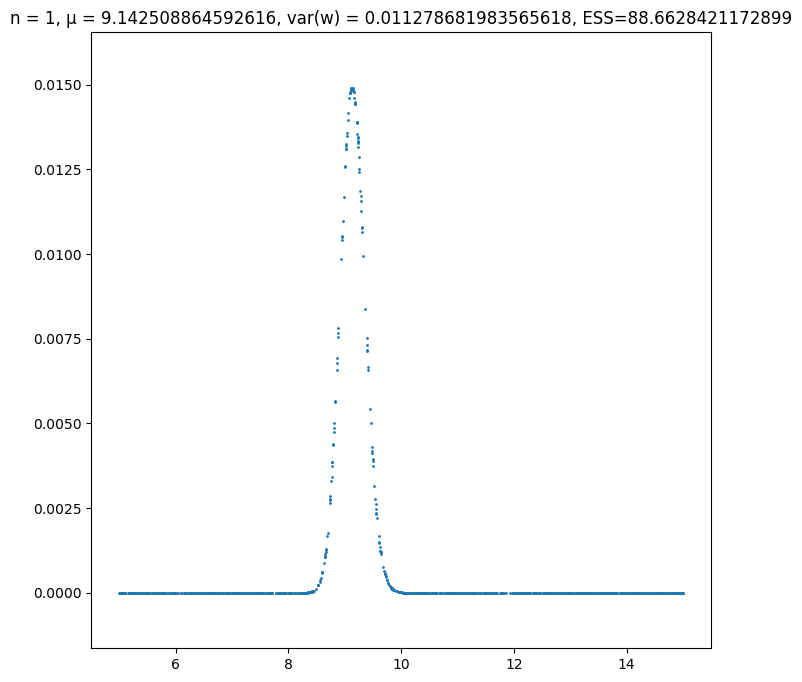

In [7]:
using Interact

srand(42)

fig = figure()

m = 1000
mesh = 10*rand(m)+5

@manipulate for n = [1, 5, 10, 20, 30, 40, 50, 58]
    
    lhood = exp.(-(g -> likelihood(n,g)).(mesh))
    lhood = lhood / sum(lhood)
    
    wvar = sum(lhood.^2)
    
    withfig(fig) do
        title("n = $(n), μ = $(vecdot(lhood,mesh)), var(w) = $(wvar), ESS=$(sum(lhood)^2/wvar)")
        scatter(mesh, lhood,s=1)
    end
end

### MCMC implementation for gaussian error

In [155]:
function GaussianMetropolisHastings(K, prior, ϕ, γ)
    x₀ = rand(prior, 1)
    
    X = zeros(K, length(x₀))
    Y = zeros(K, length(x₀))
    W = zeros(K)
    accepted = 0
    
    w = MvNormal(γ^2*eye(length(x₀)))
    x = x₀
    ϕₓ = ϕ(x)
    
    for k=1:K
        y = x + rand(w)
        ϕₙ = ϕ(y)
        if rand() < min(1, (pdf(prior, y[1])/pdf(prior, x[1]))*exp(ϕₓ-ϕₙ))
            x = y
            ϕₓ = ϕₙ
            accepted += 1
        end
        
        W[k] = ϕₙ
        Y[k,:] = y
        X[k,:] = x
    end
    X, Y, exp.(-W), accepted
end

function remove_burnin(out, burninlen)
    X, Y, W, accepted = out
    (X[burninlen+1:end], Y[burninlen+1:end],W[burninlen+1:end],accepted)
end

remove_burnin (generic function with 1 method)

### MCMC run

In [157]:
srand(42)
out = GaussianMetropolisHastings(10000, prior, g -> likelihood(n_measurements, g[1]), 0.05);

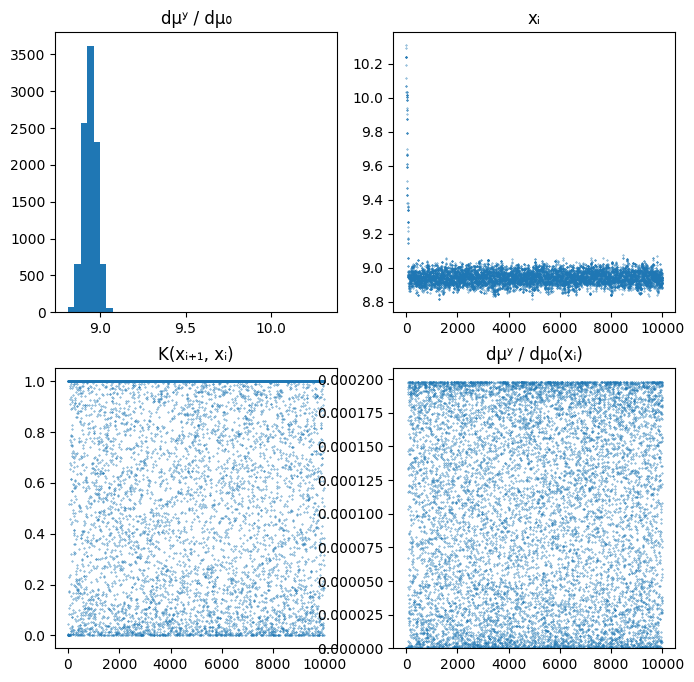

6246 / 10000 of the sampled particles were accepted (62.0%)
        
The expectation estimation is of 8.947943281264562


In [158]:
plotMCMC(out)

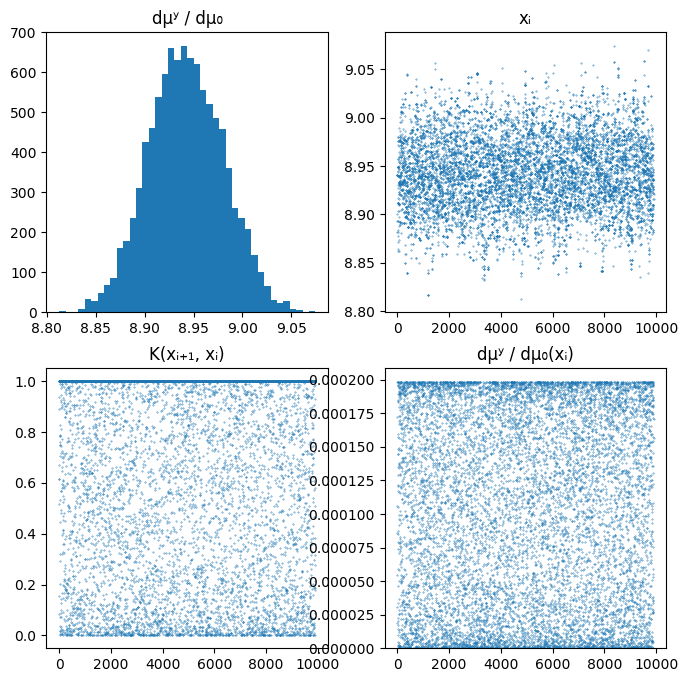

6246 / 9900 of the sampled particles were accepted (63.0%)
        
The expectation estimation is of 8.94250009103926


In [162]:
outt = remove_burnin(out, 100)
plotMCMC(outt)

### Result

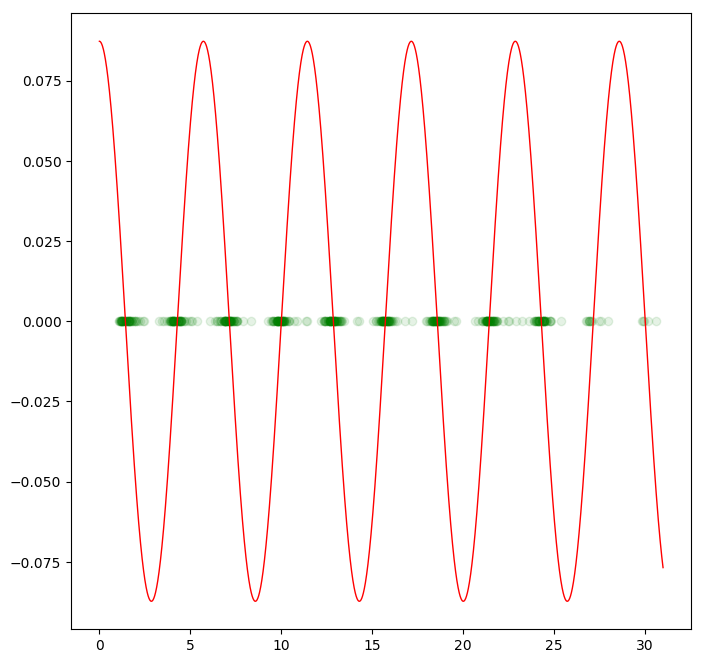

PyObject <matplotlib.collections.PathCollection object at 0x7fc4cc344d10>

In [169]:
flat_measurements = load_flat_data()
evaluation_mesh=collect(0:0.01:31)

Θ₀ = [5*pi/180, 0]
function dΘ(g)
    Θ -> [Θ[2], -g*sin(Θ[1])/7.4]
end

Gg = rk4s(dΘ(mean(outt[1])), Θ₀, evaluation_mesh, 0.01)[:,1]
plot(evaluation_mesh,Gg,c="red",linewidth=1)
scatter(flat_measurements, zeros(flat_measurements), c="green",marker="o",alpha=0.1) 